In [11]:
# Essentials
import numpy as np
from matplotlib import pyplot
import tensorflow
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.utils import np_utils
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Activation
from keras.callbacks import  Callback, EarlyStopping
import matplotlib.pyplot as plt
from matplotlib import gridspec
import random
import imageio
import os
import cv2
import glob
random.seed(42)

In [12]:
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

In [13]:
# Fetch the dataset form Github
!git clone https://github.com/borate267/inaturalist-dataset.git

fatal: destination path 'inaturalist-dataset' already exists and is not an empty directory.


In [14]:
 # Load training and testing dataset

def data_for_testing(data_aug, batch_size):
  if data_aug:
      datagen = ImageDataGenerator(
                rotation_range=45, 
                width_shift_range=0.2, 
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2, 
                horizontal_flip=True, 
                fill_mode='reflect',
                rescale=1./255
                )
  else:
      datagen = ImageDataGenerator(rescale=1./255)

  train_data = datagen.flow_from_directory(
              directory='inaturalist-dataset/train',
              target_size = (128,128),
              batch_size=batch_size,
              class_mode="categorical",
              shuffle=True,
              seed=123)


  test_data = datagen.flow_from_directory(
            directory='inaturalist-dataset/val',
            target_size=(128,128),
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=1234)
  return test_data, train_data

In [15]:
def test():
    
    best_kernel_size = [(3,3),(3,3),(3,3),(3,3),(3,3)]
    best_weight_decay = 0
    best_dropout = 0.2
    best_learning_rate = 1e-4
    best_activation = 'selu'
    best_batch_size = 64
    best_batch_norm = 'false'
    best_filt_org = [32,64,64,128,128]
    best_data_augment = 'true'
    best_num_dense = 256
    
    ### NOTE: Since Batch_norm == 'false', it has not been added in the sequential model 

    # Determine input shape
    input_shape = (128, 128, 3)
    
    # Define the model architecture
    model = Sequential()
    
    filter = best_filt_org
      
    # Layer one
    model.add(Conv2D(filters = filter[0], kernel_size = best_kernel_size[0],padding = 'same', 
                    input_shape = input_shape, kernel_regularizer=regularizers.l2(best_weight_decay)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    # Layer two
    model.add(Conv2D(filters = filter[1], kernel_size = best_kernel_size[1],padding = 'same', 
                    input_shape = input_shape, kernel_regularizer=regularizers.l2(best_weight_decay)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    # Layer three
    model.add(Conv2D(filters = filter[2], kernel_size = best_kernel_size[2],padding = 'same', 
                    input_shape = input_shape, kernel_regularizer=regularizers.l2(best_weight_decay)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer four
    model.add(Conv2D(filters = filter[3], kernel_size = best_kernel_size[3],padding = 'same', 
                    input_shape = input_shape, kernel_regularizer=regularizers.l2(best_weight_decay)))
    model.add(Activation('elu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    

    # Layer five
    model.add(Conv2D(filters = filter[4], kernel_size = best_kernel_size[4],padding = 'same', 
                    input_shape = input_shape, kernel_regularizer=regularizers.l2(best_weight_decay)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # FC layer
    model.add(Flatten())
    model.add(Dense(best_num_dense, activation = best_activation, kernel_regularizer = regularizers.l2(best_weight_decay)))
    model.add(Dropout(best_dropout))

    # Output layer
    model.add(Dense(10, activation = "softmax"))

    # Define the optimizer
    #optimizer = Adam(lr= best_learning_rate, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=['accuracy'])

    train_data, test_data = data_for_testing(best_data_augment, best_batch_size)

    model.fit(train_data, epochs=1)
    
    model.evaluate(test_data, batch_size = best_batch_size)

    model.save("model-best.h5")

    return model
  

In [16]:
model = test()

Found 9999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
157/157 [==============================] - 138s 879ms/step - loss: 2.1972 - accuracy: 0.2074


## Visualisation

In [ ]:
class_names = {0:'Amphibia', 1:'Animalia', 2:'Arachnida',3: 'Aves',4: 'Fungi',
              5: 'Insecta', 6:'Mammalia', 7:'Mollusca', 8:'Plantae',9: 'Reptilia'}

img_size = 128
dir = 'inaturalist-dataset/val'

vis_test_images = []
vis_true_labels = []


for label, name in class_names.items():
  list_images = os.listdir(dir+'/'+name)
  res = []
  for j in range(3):
    dummy = random.randint(0, 199)
    res.append(list_images[dummy])
  for image_name in res:
      image = imageio.imread(dir+'/'+name+'/'+image_name)
      if np.ndim(image) == 3:
        vis_test_images.append(cv2.resize(image, (img_size,img_size)))
        vis_true_labels.append(class_names[label])

vis_test_images = np.array(vis_test_images)
vis_test_images = vis_test_images/255.0

# Plotting the figure
fig = plt.figure(figsize=(60,50))

gs = gridspec.GridSpec(10, 3, width_ratios=[1, 1, 1], wspace=0.0, hspace=1.0, top=0.95, bottom=0.05, left=0.7, right=0.845) 
k = 0
for i in range(10):
    for j in range(3):
      ax = plt.subplot(gs[i,j])
      img = vis_test_images[k]
      ax.imshow(img)
      prediction = model.predict(img.reshape(1,128, 128, 3))[0]
      true_label = vis_true_labels[k]
      k = k + 1
      ax.axis('off')
      ax.set_title("True Label: " + true_label + "\nPredicted: " + class_names[np.argmax(prediction)])

#plt.show()


In [ ]:
# Visualising the filters

for layer in model.layers:
	if 'conv' not in layer.name:
		continue
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

filters, biases = model.layers[0].get_weights()

# Normalize filter values to 0-1 
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plotting the figure
fig = plt.figure(figsize=(128,128))

gs = gridspec.GridSpec(32, 3, width_ratios=[1, 1, 1], wspace=0.0, hspace=0.5, top=0.95, bottom=0.05, left=0.7, right=0.845) 

# plot first few filters
n_filters, ix = 32, 1

for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(3):
      ax = plt.subplot(gs[i,j])
      ax.imshow(f[:, :, j], cmap='gray')
      ax.set_xticklabels([])
      ax.set_yticklabels([])

plt.show()


## Guided Backpropogation

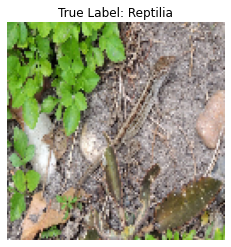

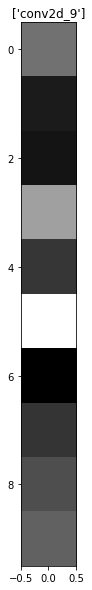

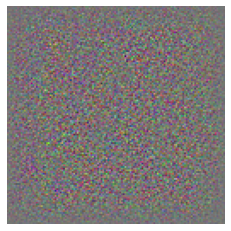

In [45]:
# run the function test() with activation 'relu' and then run the remaining portion of this code

import tensorflow as tf

index = 28
# Load the image and pre-process
image = vis_test_images[index]
image_tensor = np.expand_dims(image, axis=0)

# Display the image tensor
plt.imshow(image_tensor[0])
plt.title("True Label: " + vis_true_labels[index])
plt.axis("off")
plt.show()

#print(image_tensor.shape)

# we are interested in visulaising the output of 10 neurons in the CONV5 layer
activation_model = tf.keras.models.Model([model.inputs],[model.get_layer("conv2d_9").output])

# Creating custom gradients
@tf.custom_gradient
def guidedRelU(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

# Apply guided ReLu on activation layers 
for layer in model.layers[1:]:
    if hasattr(layer, 'activation') and layer.activation == tf.keras.activations.selu:
        layer.activation = guidedRelU

# Finding gradients of the target class score wrt feature maps
with tf.GradientTape() as g:
  inputs = tf.cast(image_tensor, tf.float32)
  g.watch(inputs)
  outputs = activation_model(inputs)[0]

target_gradient = g.gradient(outputs,inputs)[0]

#print(np.shape(outputs))

CONV5_layer_activation = outputs

layer_names = ['conv2d_9']

#np.shape(CONV5_layer_activation)= (1,size,size,num_features)
#num_features = CONV5_layer_activation.shape[-1]
#size = CONV5_layer_activation.shape[1] 
#print(num_features)
#print(size)

num_features = 10
size = 1
num_imag_in_row = 1
num_cols = num_features // num_imag_in_row
display_grid = np.ones((size * num_cols, num_imag_in_row * size))

k = 1
j = 1
for col in range(num_cols): 
  for row in range(num_imag_in_row):
    channel_image = CONV5_layer_activation[j, k, col * num_imag_in_row + row]
    display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
  
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.title(layer_names)
plt.grid(False)
plt.imshow(display_grid, aspect='auto',cmap='gray')  
plt.show()                                         


# Guided backprop gradient visualisation

grad_image = np.dstack((
            target_gradient[:, :, 0],
            target_gradient[:, :, 1],
            target_gradient[:, :, 2],
        ))       
grad_image = grad_image - np.min(grad_image)
grad_image = grad_image/grad_image.max()
imgplot = plt.imshow(grad_image)
plt.axis("off")
plt.show()



